<div style="text-align: center;">
    <h1>Versão em andamento</h1>
</div>

# Importar Bibliotecas

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE 
from collections import Counter
import matplotlib.pyplot as plt

# Carregar e explorar o dataset

In [ ]:
df = pd.read_csv('C:/Users/wesle/machine-learning-tecnicas/Dataset/depression_data.csv')

In [ ]:
# Visualizar as Primeiras Linhas
print(df.head(5))

In [ ]:
# Resumo Estatístico
print(df.describe())

In [ ]:
# Informações do DataFrame
print(df.info())

In [ ]:
# Valores Únicos por Coluna
print(df.nunique())

In [ ]:
# Verificar Dados Ausentes
print(df.isnull().sum())

In [ ]:
# Distribuição da Variável Alvo
plt.figure(figsize=(8, 6))
sns.countplot(x='depression_diagnosis', data=df)
plt.title('Distribuição da Variável Alvo')
plt.xlabel('Classes')
plt.ylabel('Contagem')
plt.show()

# Pré-processamento dos dados

In [ ]:
df.drop('id', axis = 1, inplace = True)

# Random Forest
Implementação do modelo

In [29]:
#Instanciando o modelo
random_forest = RandomForestClassifier(n_estimators=100, random_state = 42)

### Sem resample

In [31]:
#dividindo o dataset em treino e teste com todas as características (holdout)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

random_forest.fit(X_train, y_train)

y_pred_all_features = random_forest.predict(X_test)

#avaliando o modelo com o cross-validation
cv_scores = cross_val_score(random_forest, X_train, y_train, cv = 10, scoring='accuracy')

print('Relatório do modelo sem resample com todas as características\n\n', classification_report(y_test, y_pred_all_features))
print(f"Acurácia média da validação cruzada: {cv_scores.mean() * 100:.2f}%")
print(f"Desvio padrão da acurácia: {cv_scores.std() * 100:.2f}%")

Relatório do modelo sem resample com todas as características

               precision    recall  f1-score   support

           0       0.99      0.98      0.98       218
           1       0.58      0.70      0.64        10

    accuracy                           0.96       228
   macro avg       0.78      0.84      0.81       228
weighted avg       0.97      0.96      0.97       228

Acurácia média da validação cruzada: 93.95%
Desvio padrão da acurácia: 2.36%


### Com resample

In [33]:
#dividindo o dataset em treino e teste com todas as características (holdout) e reamostrado
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state = 42)

random_forest.fit(X_train, y_train)

y_pred_all_features_resampled = random_forest.predict(X_test)

#avaliando o modelo com o cross-validation
cv_scores = cross_val_score(random_forest, X_train, y_train, cv = 10, scoring='accuracy')

print('Relatório do modelo com resample com todas as características\n\n', classification_report(y_test, y_pred_all_features_resampled))
print(f"Acurácia média da validação cruzada: {cv_scores.mean() * 100:.2f}%")
print(f"Desvio padrão da acurácia: {cv_scores.std() * 100:.2f}%")

Relatório do modelo com resample com todas as características

               precision    recall  f1-score   support

           0       0.94      0.86      0.90       204
           1       0.88      0.95      0.91       212

    accuracy                           0.91       416
   macro avg       0.91      0.91      0.91       416
weighted avg       0.91      0.91      0.91       416

Acurácia média da validação cruzada: 93.40%
Desvio padrão da acurácia: 1.91%


### Importância de atributos

Nível de importância das características:
                 Feature  Importance
9   depression_treatment    0.208603
15         epworth_score    0.116573
3                    bmi    0.096294
5              phq_score    0.092139
10             gad_score    0.075791
2                 gender    0.066599
0            school_year    0.051337
1                    age    0.050551
13     anxiety_diagnosis    0.040836
6    depression_severity    0.039666
7         depressiveness    0.038772
11      anxiety_severity    0.028938
4                who_bmi    0.025530
14     anxiety_treatment    0.021481
8               suicidal    0.017895
16            sleepiness    0.017313
12           anxiousness    0.011682


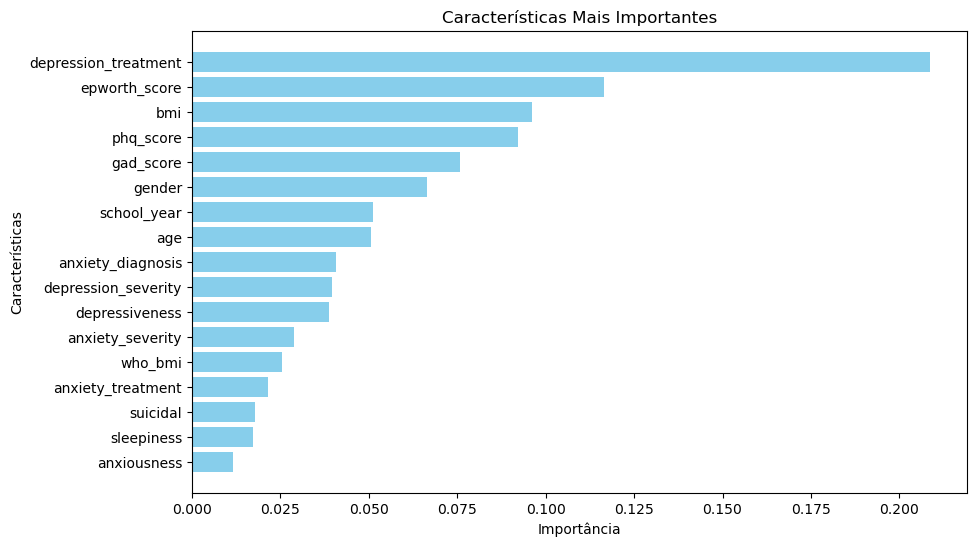

In [35]:
feature_importances = random_forest.feature_importances_

# Organizando em um DataFrame para melhor visualização
features_df = pd.DataFrame({
    'Feature': X.columns,  
    'Importance': feature_importances
})

# Ordenando pela importância em ordem decrescente
features_df = features_df.sort_values(by='Importance', ascending=False)

# Exibindo as importantes segundo o critério defaul Gini do Random Forest
print("Nível de importância das características:")
print(features_df)

plt.figure(figsize=(10, 6))
plt.barh(features_df['Feature'], features_df['Importance'], color='skyblue')
plt.xlabel('Importância')
plt.ylabel('Características')
plt.title('Características Mais Importantes')
plt.gca().invert_yaxis()  
plt.show()

### Selecionando os melhores atributos

In [37]:
selector = SelectKBest(score_func = f_classif, k=5)
X_selected = selector.fit_transform(X, y)
view_features = X.columns[selector.get_support()]

print("Características selecionadas:\n", view_features)

Características selecionadas:
 Index(['depression_severity', 'depressiveness', 'depression_treatment',
       'anxiety_diagnosis', 'anxiety_treatment'],
      dtype='object')


In [38]:
#novo SMOTE para as características selecionadas
X_resampled_selected, y_resampled_selected = smt.fit_resample(X_selected, y)
print(f"Distribuição das classes após SMOTE: {y_resampled_selected.value_counts()}")

Distribuição das classes após SMOTE: depression_diagnosis
0    693
1    693
Name: count, dtype: int64


In [39]:
#divisão de treino e teste com os melhores atributos (holdout)
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_resampled_selected, y_resampled_selected, test_size=0.3, random_state = 42)

random_forest.fit(X_train_selected, y_train_selected)

y_pred_selected_features = random_forest.predict( X_test_selected)

#avaliando o modelo com o cross-validation
cv_scores = cross_val_score(random_forest, X_train_selected,  y_train_selected, cv = 10, scoring='accuracy')

print('Relatório do modelo com as melhores características selecionadas\n\n', classification_report(y_test_selected, y_pred_selected_features ))
print(f"Acurácia média da validação cruzada: {cv_scores.mean() * 100:.2f}%")
print(f"Desvio padrão da acurácia: {cv_scores.std() * 100:.2f}%")

Relatório do modelo com as melhores características selecionadas

               precision    recall  f1-score   support

           0       0.89      0.97      0.93       204
           1       0.97      0.88      0.92       212

    accuracy                           0.93       416
   macro avg       0.93      0.93      0.93       416
weighted avg       0.93      0.93      0.93       416

Acurácia média da validação cruzada: 92.99%
Desvio padrão da acurácia: 2.30%


### Tunning de hiperparâmetros

In [41]:
from sklearn.model_selection import GridSearchCV 

In [42]:
param_grid = { 
    "criterion": ["gini", "entropy"], 
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20, 30], 
    "min_samples_split": [2, 4, 10], 
    "min_samples_leaf": [1, 2, 4], 
    "bootstrap": [True, False] 
}

#### sem SMOTE

In [44]:
#dividindo o dataset em treino e teste com todas as características (holdout)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [45]:
grid_search = GridSearchCV(estimator = random_forest, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train) 

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [46]:
best_params_without_smote = grid_search.best_params_
best_model_without_smote = grid_search.best_estimator_

In [48]:
print(f"Melhores hiperparâmetros: {best_params_without_smote}")
print(f"Melhor modelo: {best_model_without_smote}")

Melhores hiperparâmetros: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Melhor modelo: RandomForestClassifier(min_samples_split=10, n_estimators=200, random_state=42)


#### com SMOTE

In [50]:
#dividindo o dataset em treino e teste com todas as características (holdout)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state = 42)

In [51]:
grid_search_resampled = GridSearchCV(estimator = random_forest, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search_resampled.fit(X_train, y_train) 

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [52]:
best_params_with_smote = grid_search_resampled.best_params_
best_model_with_smote = grid_search_resampled.best_estimator_

In [53]:
print(f"Melhores hiperparâmetros: {best_params_with_smote}")
print(f"Melhor modelo: {best_model_with_smote}")

Melhores hiperparâmetros: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Melhor modelo: RandomForestClassifier(bootstrap=False, criterion='entropy', random_state=42)


### Treinamento com o melhor modelo sem SMOTE

In [64]:
#dividindo o dataset em treino e teste com todas as características (holdout)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

best_model_without_smote.fit(X_train, y_train)

y_pred_all_features = best_model_without_smote.predict(X_test)

#avaliando o modelo com o cross-validation
cv_scores = cross_val_score(best_model_without_smote, X_train, y_train, cv = 10, scoring='accuracy')

print('Relatório do melhor modelo sem resample com todas as características\n\n', classification_report(y_test, y_pred_all_features))
print(f"Acurácia média da validação cruzada: {cv_scores.mean() * 100:.2f}%")
print(f"Desvio padrão da acurácia: {cv_scores.std() * 100:.2f}%")

Relatório do melhor modelo sem resample com todas as características

               precision    recall  f1-score   support

           0       0.99      0.97      0.98       218
           1       0.57      0.80      0.67        10

    accuracy                           0.96       228
   macro avg       0.78      0.89      0.82       228
weighted avg       0.97      0.96      0.97       228

Acurácia média da validação cruzada: 93.95%
Desvio padrão da acurácia: 2.78%


### Treinamento com o melhor modelo com SMOTE

In [66]:
#dividindo o dataset em treino e teste com todas as características (holdout)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state = 42)

best_model_with_smote.fit(X_train, y_train)

y_pred_all_features = best_model_with_smote.predict(X_test)

#avaliando o modelo com o cross-validation
cv_scores = cross_val_score(best_model_with_smote, X_train, y_train, cv = 10, scoring='accuracy')

print('Relatório do melhor modelo com resample com todas as características\n\n', classification_report(y_test, y_pred_all_features))
print(f"Acurácia média da validação cruzada: {cv_scores.mean() * 100:.2f}%")
print(f"Desvio padrão da acurácia: {cv_scores.std() * 100:.2f}%")

Relatório do melhor modelo com resample com todas as características

               precision    recall  f1-score   support

           0       0.96      0.88      0.92       204
           1       0.89      0.96      0.93       212

    accuracy                           0.92       416
   macro avg       0.92      0.92      0.92       416
weighted avg       0.92      0.92      0.92       416

Acurácia média da validação cruzada: 92.68%
Desvio padrão da acurácia: 1.08%
